In [1]:
# libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statistics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer 

In [2]:
df = pd.read_pickle(r'C:\Users\Aditi\Downloads\Data_ANZ.pk1')

In [3]:
df.head()

,status,card_present_flag,account,currency,long_lat,txn_description,merchant_id,first_name,balance,date,...,amount,transaction_id,country,customer_id,merchant_long_lat,movement,month,dayofweek,hour,category
0,authorized,1.0,ACC-1598451071,AUD,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,Diana,35.39,2018-08-01,...,16.25,a623070bfead4541a6b0fff8a09e706c,Australia,CUS-2487424745,153.38 -27.99,debit,8,2,01,Purchase
1,authorized,0.0,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,Diana,21.20,2018-08-01,...,14.19,13270a2a902145da9db4c951e04b51b9,Australia,CUS-2487424745,151.21 -33.87,debit,8,2,01,Purchase
2,authorized,1.0,ACC-1222300524,AUD,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,Michael,5.71,2018-08-01,...,6.42,feb79e7ecd7048a5a36ec889d1a94270,Australia,CUS-2142601169,151.21 -33.87,debit,8,2,01,Purchase
3,authorized,1.0,ACC-1037050564,AUD,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,Rhonda,2117.22,2018-08-01,...,40.90,2698170da3704fd981b15e64a006079e,Australia,CUS-1614226872,153.05 -26.68,debit,8,2,01,Purchase
4,authorized,1.0,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,Diana,17.95,2018-08-01,...,3.25,329adf79878c4cf0aeb4188b4691c266,Australia,CUS-2487424745,153.44 -28.06,debit,8,2,01,Purchase


In [4]:
# Feature Engineering

In [5]:
# Our target variable is annual salary

In [6]:
# Let's check salary payment frequency for each customer

salary_df = pd.DataFrame({"customer_id": df.customer_id.unique()})
salary_df.head()

,customer_id
0,CUS-2487424745
1,CUS-2142601169
2,CUS-1614226872
3,CUS-2688605418
4,CUS-4123612273


In [7]:
# let's get the salary amount for each unique id

freq = []
amt = []

for i in range(len(salary_df)):
    salary = df.loc[(df.customer_id == salary_df.customer_id[i]) & (df.txn_description == "PAY/SALARY"), ['date', 'amount']].groupby("date", as_index = False).sum()
    count = len(salary)
    
    if count == 0:
        freq.append(np.nan)
        amt.append(np.nan)
        
    else:
        day_pay = []
        for i in range(len(salary)-1):
            day_pay.append((salary.date[i+1] - salary.date[i]).days)
        freq.append(max(day_pay))
        amt.append(statistics.mode(salary.amount))

In [8]:
salary_df["salary_freq"] = freq
salary_df['salary_amt'] = amt
salary_df['annual_salary'] = salary_df['salary_amt']/salary_df['salary_freq']*365

In [9]:
salary_df.head()

,customer_id,salary_freq,salary_amt,annual_salary
0,CUS-2487424745,7,1013.67,52855.650000
1,CUS-2142601169,7,1002.13,52253.921429
2,CUS-1614226872,7,892.09,46516.121429
3,CUS-2688605418,14,2320.30,60493.535714
4,CUS-4123612273,7,1068.04,55690.657143


E:\Program Files\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, "Distribution of customer's salary amount")

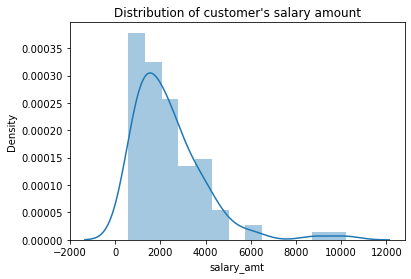

In [10]:
sns.distplot(salary_df.salary_amt)
plt.title('Distribution of customer\'s salary amount')

E:\Program Files\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, "Distribution of customer's annual salary")

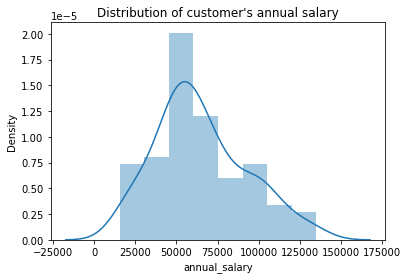

In [11]:
sns.distplot(salary_df.annual_salary)
plt.title('Distribution of customer\'s annual salary')

In [12]:
# let's create predictor variables for each customer

In [13]:
unique_id = df.customer_id.unique()
len(unique_id)

100

In [14]:
# average number of weekly transactions

avg_week_tran = []

for i in unique_id:
    lst = df.loc[df.customer_id == i, 'date']
    avg_week_tran.append(round(len(lst)/lst.nunique())*7)

len(avg_week_tran)

100

In [15]:
# Maximum amount

max_amt = []

for i in unique_id:
    lst = df.loc[df.customer_id == i, 'amount']
    max_amt.append(max(lst))

max_amt[:10]

[1452.21,
 2349.55,
 892.09,
 2320.3,
 1068.04,
 2840.15,
 2280.36,
 2639.76,
 3903.95,
 2588.01]

In [16]:
# count of large transactions (above 100)

no_trans = []

for i in unique_id:
    lst = df.loc[df.customer_id == i, 'amount']
    ct = 0
    
    for j in lst:
        if j > 100:
            ct += 1
    no_trans.append(ct)

no_trans[:5]

[22, 23, 22, 25, 32]

In [17]:
# number of dats with transactions

no_days_with_trans = []

for i in unique_id:
    lst = df.loc[df.customer_id == i, "date"]
    no_days_with_trans.append(lst.nunique())
    
no_days_with_trans[:5]

[85, 74, 76, 63, 44]

In [18]:
# Average transaction amount

avg_trans_amt = []

for i in unique_id:
    lst = df.loc[df.customer_id==i, 'amount']
    avg_trans_amt.append(lst.mean())
    
avg_trans_amt[:10]

[45.34877162629756,
 78.20610561056101,
 74.46501930501928,
 159.3041860465116,
 166.50835820895517,
 99.56965753424659,
 314.3242982456141,
 220.85247422680413,
 297.51034482758627,
 261.89141104294487]

In [19]:
# median of balance

med_balance = []

for i in unique_id:
    lst = df.loc[df.customer_id==i, 'balance']
    med_balance.append(lst.median())
    
med_balance[:10]

[1580.4,
 1132.66,
 3618.5,
 5616.63,
 6162.45,
 5893.355,
 13214.74,
 12992.23,
 12093.89,
 12794.13]

In [20]:
# state of residency

state = []

for i in unique_id:
    lst = df.loc[df.customer_id==i, 'merchant_state']
    state.append(statistics.mode(lst))
    
state[:10]

['QLD', 'NSW', 'QLD', 'NSW', 'VIC', 'WA', 'n/a', 'n/a', 'NSW', 'n/a']

In [21]:
# now let's include age and gender

age = []

for i in unique_id:
    lst = df.loc[df.customer_id == i, "age"]
    age.append(statistics.mode(lst))

age[:5]

[26, 38, 40, 20, 43]

In [22]:
gender = []

for i in unique_id:
    lst = df.loc[df.customer_id == i, "gender"]
    gender.append(statistics.mode(lst))

gender[:10]

['F', 'M', 'F', 'M', 'F', 'F', 'M', 'M', 'M', 'M']

In [23]:
# Let's create a dataframe putting all the predictor variables together

In [24]:
pred_df = pd.DataFrame({'customer_id': unique_id,
                        'avg_no_week_trans': avg_week_tran,
                        'max_amt': max_amt,
                        'no_large_trans': no_trans,
                        'avg_trans_amt': avg_trans_amt,
                        'median_balance': med_balance,
                        'state': state,
                        'age': age,
                        'gender': gender})

pred_df.head()

,customer_id,avg_no_week_trans,max_amt,no_large_trans,avg_trans_amt,median_balance,state,age,gender
0,CUS-2487424745,49,1452.21,22,45.348772,1580.40,QLD,26,F
1,CUS-2142601169,28,2349.55,23,78.206106,1132.66,NSW,38,M
2,CUS-1614226872,21,892.09,22,74.465019,3618.50,QLD,40,F
3,CUS-2688605418,14,2320.30,25,159.304186,5616.63,NSW,20,M
4,CUS-4123612273,21,1068.04,32,166.508358,6162.45,VIC,43,F


In [25]:
# target variable
salary_df.head()

,customer_id,salary_freq,salary_amt,annual_salary
0,CUS-2487424745,7,1013.67,52855.650000
1,CUS-2142601169,7,1002.13,52253.921429
2,CUS-1614226872,7,892.09,46516.121429
3,CUS-2688605418,14,2320.30,60493.535714
4,CUS-4123612273,7,1068.04,55690.657143


In [26]:
# concat annual salary column to features dataframe  
new_df = pd.concat([pred_df, salary_df.annual_salary], axis = 1)
new_df.head()

,customer_id,avg_no_week_trans,max_amt,no_large_trans,avg_trans_amt,median_balance,state,age,gender,annual_salary
0,CUS-2487424745,49,1452.21,22,45.348772,1580.40,QLD,26,F,52855.650000
1,CUS-2142601169,28,2349.55,23,78.206106,1132.66,NSW,38,M,52253.921429
2,CUS-1614226872,21,892.09,22,74.465019,3618.50,QLD,40,F,46516.121429
3,CUS-2688605418,14,2320.30,25,159.304186,5616.63,NSW,20,M,60493.535714
4,CUS-4123612273,21,1068.04,32,166.508358,6162.45,VIC,43,F,55690.657143


In [27]:
# checking for missing values

new_df.isna().sum()

customer_id          0
avg_no_week_trans    0
max_amt              0
no_large_trans       0
avg_trans_amt        0
median_balance       0
state                0
age                  0
gender               0
annual_salary        0
dtype: int64

In [28]:
# Preprocessing

In [29]:
x = new_df.drop(['customer_id', 'annual_salary'], axis=1)
y = new_df.annual_salary

print('x shape: ', x.shape)
print('y shape: ', y.shape)

x shape:  (100, 8)
y shape:  (100,)


In [30]:
x_tr, x_test, y_tr, y_test = train_test_split(x,y, test_size=0.3, random_state=25)

print('x_tr shape: ', x_tr.shape)
print('y_tr shape: ', y_tr.shape)
print('x_test shape: ', x_test.shape)
print('y_test shape: ', y_test.shape)

x_tr shape:  (70, 8)
y_tr shape:  (70,)
x_test shape:  (30, 8)
y_test shape:  (30,)


In [31]:
# Crete column transformer 
ohe = OneHotEncoder(sparse = False)
scaler = StandardScaler()
column_transform = make_column_transformer((ohe, ["state", "gender"]), 
                                           (scaler, ["avg_no_week_trans", "max_amt", "no_large_trans", "avg_trans_amt", "median_balance", "age"]))

In [32]:
# Linear Regression Model

In [33]:
# Instantiate model and pipeline
lm = LinearRegression()
lm_pipeline = make_pipeline(column_transform, lm)

# Fit pipeline and make predictions 
lm_pipeline.fit(x_tr, y_tr)
lm_pred = lm_pipeline.predict(x_test)

In [34]:
np.sqrt(mean_squared_error(lm_pred, y_test))

23441.285141902372

In [35]:
r2_score(y_test, lm_pred)

0.3288787277327756

In [36]:
# Decision Tree Model

In [37]:
# Instantiate model and pipeline 
dtree = DecisionTreeRegressor()
dtree_pipeline = make_pipeline(column_transform, dtree)

# Fit pipeline and make predictions 
dtree_pipeline.fit(x_tr, y_tr)
dtree_pred = dtree_pipeline.predict(x_test)

In [38]:
np.sqrt(mean_squared_error(dtree_pred, y_test))

25201.237718421064

In [39]:
r2_score(y_test, dtree_pred)

0.2243212190901378

In [40]:
# conclusion

# Both Linear Regression and Decision Trees have the RMSE value more than 20000 and have a very small r2 score.
# Hence we can say that both the models are providing highly inaccurate results. More data is required to develop a better model